In [1]:
%load_ext notexbook

In [2]:
%texify -lh 1.5 --code-font Monaco -mdfs 16

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/pytorch-beautiful-ml-data/pydata-global?filepath=part_2/case_study_sentiment140.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/leriomaggio/pytorch-beautiful-ml-data/blob/pydata-global/part_2/case_study_sentiment140.ipynb)
</span>

<span class="fn"><i>[Note]: </i> This notebook has been designed using the [$\text{no}\TeX\text{book}$](https://github.com/leriomaggio/notexbook-jupyter-theme) Jupyter notebook theme. 
Please **trust** the notebook to enable the theme.</span>

# A PyTorch Dataset for Twitter Sentiments

In this notebook we will be working towards the creation of a `torch.utils.data.Dataset`  for sentiment analysis on **Twitter** messages. 

We will be using the `Sentiment140` dataset, and we will build our solution step-by-step, starting from the very beginning (i.e. **download** the dataset), up to `Dataset` class design, after some preprocessing, and cleaning. 

**Note**: The actual code of the `Sentiment140Dataset` is left intentionally blank as an exercise for the reader. However, this notebook will guide you through building on the very components that will be included in the `Dataset` classes. 

A final list of requirements for the `Dataset` class is also provided, to guide you through its implementation.

## The `Sentiment140` Dataset

The [`Sentiment140`](http://help.sentiment140.com/for-students) is a popular and publicly [available](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip) dataset of **twitter** messages, and their corresponding *sentiment*. 
This dataset has been originally created and used as the reference dataset for one of the first _sentiment analysis_ methods for twitter based on **machine learning**. More information are available in their original [paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf).

#### _Raw_ Data

The `Sentiment140` original dataset is provided as a compressed file, containing the training and the test dataset in `CSV` format (with `emojis` removed).

The CSV format has `6` fields:

- the polarity of the tweet (i.e. `0` = negative, `2` = neutral, `4` = positive)
- the id of the tweet (e.g. `2087`)
- the date of the tweet (e.g. `Sat May 16 23:58:44 UTC 2009`)
- the query (e.g. `latex`). If there is no query, then this value is `NO_QUERY`.
- the user that tweeted (e.g. `robotickilldozr`)
- the text of the tweet (e.g. `Latex is cool`)

<span class="fn"><i>[Source]: </i>[Sentiment140](http://help.sentiment140.com/for-students)</span>



The data can be downloaded at [this](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip) link. 

Similarly to what we have done for the `FERDataset`, we will be using the `download_and_extract_archive` utility function included in the `torchvision.datasets.utils` module[$^{2}$](#fn2).

<span id="fn2"><i>[2]: </i> This function is used in **all** the `VisionDataset` instances included in `torchvision.datasets` classes.</span>

In [3]:
from pathlib import Path
from torchvision.datasets.utils import download_and_extract_archive

In [4]:
SENTIMENT140_URL = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
DOWNLOAD_ROOT = Path(".")
FILENAME = "sentiment140.zip"
MD5 = "1647eb110dd2492512e27b9a70d5d1bc"

In [5]:
download_and_extract_archive(url=SENTIMENT140_URL, download_root=DOWNLOAD_ROOT, 
                             filename=FILENAME, md5=MD5)

Using downloaded and verified file: ./sentiment140.zip
Extracting ./sentiment140.zip to .


In [6]:
!ls *.csv

testdata.manual.2009.06.14.csv
training.1600000.processed.noemoticon.csv


**Great**! 🙌

---

So, the `Sentiment140` dataset comes already _partitioned_ into **training set** (i.e. `training.1600000.processed.noemoticon.csv`), and **test set** (i.e. `testdata.manual.2009.06.14.csv`)

Before rushing into loading the data into a `pandas.DataFrame`, let's first have a look at their content to see what we should expect!

In [7]:
!head -n 3 training.1600000.processed.noemoticon.csv

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
"0","1467810917","Mon Apr 06 22:19:53 PDT 2009","NO_QUERY","mattycus","@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds"


In [8]:
!head -n 3 testdata.manual.2009.06.14.csv

"4","3","Mon May 11 03:17:40 UTC 2009","kindle2","tpryan","@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
"4","4","Mon May 11 03:18:03 UTC 2009","kindle2","vcu451","Reading my kindle2...  Love it... Lee childs is good read."
"4","5","Mon May 11 03:18:54 UTC 2009","kindle2","chadfu","Ok, first assesment of the #kindle2 ...it fucking rocks!!!"


We can immediately notice that: 
- **no** `header` is provided for the columns, nor `index`; 
- the column separator used is the `","` as expected; 
- all the fields are delimited by doublequotes, (`datetime`, and sentiment polarity included!);
- the same format is shared for the testing data. 

##### Loading data into a `pandas.DataFrame`

In [9]:
import pandas as pd

In [10]:
cols = ["polarity","tweet_id","datetime","query_string","user_id","text"]
sent140_df_train = pd.read_csv("./training.1600000.processed.noemoticon.csv",
                               header=None, names=cols, encoding="latin-1")

sent140_df_test = pd.read_csv("./testdata.manual.2009.06.14.csv",
                               header=None, names=cols, encoding="latin-1")

Let's have a look at the _raw_ data

In [11]:
sent140_df_train.shape, sent140_df_test.shape

((1600000, 6), (498, 6))

In [12]:
sent140_df_train.head(n=5)

,polarity,tweet_id,datetime,query_string,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
sent140_df_test.head(n=5)

,polarity,tweet_id,datetime,query_string,user_id,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


#### Labels Encoding and Samples-per-class Distribution

Let's now **encode** the `polarity` as a *categorical* variable, using `pd.Categorical`:

In [14]:
sent140_df_train["polarity"] = pd.Categorical(sent140_df_train.polarity, 
                                              categories=[0, 2, 4], ordered=True)
sent140_df_test["polarity"] = pd.Categorical(sent140_df_test.polarity, 
                                             categories=[0, 2, 4], ordered=True)

Let's now have a look at **sample distribution** per single class, in the two partitions

In [15]:
sent140_df_train.polarity.value_counts()

4    800000
0    800000
2         0
Name: polarity, dtype: int64

Let's visualise the same distribution using a barplot (_nothing particularly fancy, I know. ed._ 🙃 )

In [16]:
from matplotlib import pyplot as plt

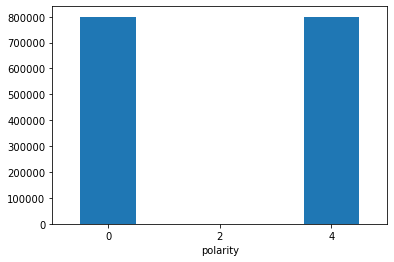

In [17]:
sent140_df_train.groupby("polarity").tweet_id.count().plot(kind='bar', rot=0)
plt.show()

In [18]:
sent140_df_test.polarity.value_counts()

4    182
0    177
2    139
Name: polarity, dtype: int64

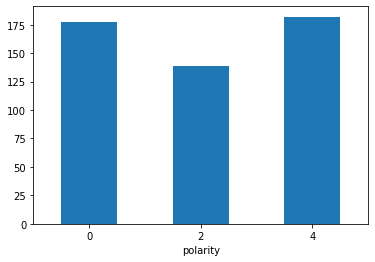

In [19]:
sent140_df_test.groupby("polarity").tweet_id.count().plot(kind='bar', rot=0)
plt.show()

In [20]:
#double check: always a good idea!
sent140_df_train.polarity.unique(), sent140_df_test.polarity.unique()

([0, 4]
 Categories (2, int64): [0 < 4],
 [4, 0, 2]
 Categories (3, int64): [0 < 2 < 4])

⚠️ **Interestingly**, there is no tweet in training set labelled as _Neutral_. On the other hand, samples in the training set are perfectly *balanced* between the two classes.

The training set contains `1.6M` tweet samples which may take a while to process on your own laptop.
So let's just limit our analysis to a subset of those. 

To do that, we will be using the `DataFrame.sample` function, to extract `1/4` of the samples (using the `frac` parameter). It will be interesting to see how this function will affect samples distributions.

In [21]:
SEED = 920  # 0b1110011000 - also 189212 is another pretty good seed 
frac = .25  # 1/4 - feel free to increase this number if you feel you can easily handle it.
sent140_sampled = sent140_df_train.sample(frac=.25, random_state=SEED)

In [22]:
sent140_sampled.polarity.value_counts()

0    200327
4    199673
2         0
Name: polarity, dtype: int64

Class distribution is _more-or-less_ the same, and definitely more realistic than the original *knife-cut* distribution[$^{\star}$](#fnstar).

<span id="fnstar"><i>[$\star$]: </i>
I wonder whether any of those tweet would also fall into the _neutral_ class... but answering that question would require a completely different tutorial, and so left to the reader to investigate 😇🕵️‍♀️</span> 

In [23]:
# from now on, this subset will be our training set of reference
sent140_df_train = sent140_sampled.copy()

#### Processing Textual Data

Let's have a look at the textual content of tweets


In [24]:
sent140_df_train.head(n=3)

,polarity,tweet_id,datetime,query_string,user_id,text
1363653,4,2049557876,Fri Jun 05 17:05:26 PDT 2009,NO_QUERY,sarahhoodspith,drove for 7 hours only to end up where she sta...
1570608,4,2188616921,Mon Jun 15 22:13:47 PDT 2009,NO_QUERY,fauzims,@herwahyu the old stuff shld stay what or u h...
1445187,4,2062350482,Sat Jun 06 22:59:29 PDT 2009,NO_QUERY,MeganDohh,@MandaLoguzzo My Sim is in Culinary School.


In [25]:
sent140_df_test.head(n=3)

,polarity,tweet_id,datetime,query_string,user_id,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."


Even at a first glance, we can easily recognise some of the very distinguishing features that the **Twitter Language Model** included in `Sentiment140` has:

1. Twitter user mentions using the `@` symbol (e.g. `@Kenichan`);
2. Presence/use of URLs;
3. Repeated letters (e.g. `loooooooovvvvvveee`).

Setting up a _robust_ and _complete_ NLP pipeline is beyond the scope of this tutorial. However, we will try to perform a quite decent _preprocessing_ to get rid of unwanted textual data, and to work with the specific language model, using the same strategy described in the original [paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf):

- replace all `@` mentions with an equivalence class token `AT_USERNAME`;
- convert all urls into its corresponding `URL` token; 
- preprocessing words so that any letter occurring more than two times in a row is replaced with two occurrences.
    *  e.g. `huuuungry`, `huuuuuuungry`, `huuuuuuuuuungry` $\mapsto$ `huungry`

In addition, we will also get rid of any `HTML` special entity (e.g. `&amp;`); *tickers*, and *hashtags*, as well as any possible non-wordly _gibberish_ tweets may contain. To do so, we will leverage on the [`str.isascii`](https://docs.python.org/3/library/stdtypes.html?highlight=isalpha#str.isascii) string method.

In [26]:
import re  # regexp-based string replace
from itertools import groupby  # used to implement the function to get rid of extra chars

We will collect these operations into two separate functions, namely `tweet_preprocessor`, and `tweet_tokenizer` later used in combination to a `sklearn.feature_extraction.text.CountVectorizer` to extract the features.

In [27]:
def tweet_preprocessor(tweet):
    """Preprocess and return tweet text."""
    # transform the tweet into lowercase
    tweet = tweet.lower()
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('(@[^\s]+)',r'AT_USERNAME',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # Remove Words composed by digits and letters (most of the time, rubbish)
    tweet = re.sub(r'([0-9]+)([a-zA-z]+)', '', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', 'URL', tweet)
    # Remove hashtags
    tweet = re.sub(r'(#(\w*))', '\g<2>', tweet)
    return tweet.strip()
    
def tweet_tokenizer(tweet):
    """Tokenize input tweet text into a series of tokens"""
    token_pattern = re.compile(r"(?u)\b\w\w+\b")
    tokens = token_pattern.findall(tweet)
    strip_repeat = lambda w: "".join(c*min(2,len(list(r))) for c, r in groupby(w))
    return list(filter(lambda t: t.isascii(), map(strip_repeat, tokens)))

Let's see how these two functions work with two sample tweets extracted from both training and test partitions, repsectively.

In [28]:
train_tweet = sent140_df_train.iloc[1].text
test_tweet = sent140_df_test.iloc[0].text

In [29]:
sent140_df_train.head()

,polarity,tweet_id,datetime,query_string,user_id,text
1363653,4,2049557876,Fri Jun 05 17:05:26 PDT 2009,NO_QUERY,sarahhoodspith,drove for 7 hours only to end up where she sta...
1570608,4,2188616921,Mon Jun 15 22:13:47 PDT 2009,NO_QUERY,fauzims,@herwahyu the old stuff shld stay what or u h...
1445187,4,2062350482,Sat Jun 06 22:59:29 PDT 2009,NO_QUERY,MeganDohh,@MandaLoguzzo My Sim is in Culinary School.
592238,0,2217901147,Wed Jun 17 21:33:45 PDT 2009,NO_QUERY,augustusvondoom,@gypsycabdriver seriously.
27571,0,1559258645,Sun Apr 19 10:40:38 PDT 2009,NO_QUERY,OakParkGirl,Apparently our efforts to save The Depot worke...


**1** Training tweet

In [30]:
train_tweet

'@herwahyu the old stuff shld stay what  or u hv information overload. reprocess all the information and join them'

In [31]:
tweet_preprocessor(train_tweet)

'AT_USERNAME the old stuff shld stay what  or u hv information overload. reprocess all the information and join them'

In [32]:
tweet_tokenizer(tweet_preprocessor(train_tweet))

['AT_USERNAME',
 'the',
 'old',
 'stuff',
 'shld',
 'stay',
 'what',
 'or',
 'hv',
 'information',
 'overload',
 'reprocess',
 'all',
 'the',
 'information',
 'and',
 'join',
 'them']

**2** Test tweet

In [33]:
test_tweet

'@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

In [34]:
tweet_preprocessor(test_tweet)

'AT_USERNAME i loooooooovvvvvveee my kindle2. not that the dx is cool, but the 2 is fantastic in its own right.'

In [35]:
tweet_tokenizer(tweet_preprocessor(test_tweet))

['AT_USERNAME',
 'loovvee',
 'my',
 'kindle2',
 'not',
 'that',
 'the',
 'dx',
 'is',
 'cool',
 'but',
 'the',
 'is',
 'fantastic',
 'in',
 'its',
 'own',
 'right']

#### Extracting Features

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
vectorizer = CountVectorizer(preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, 
                             max_features=5000, # retaining only top 5K features
                             min_df=2,  # terms appearing in at least 2 tweets
                             #ngram_range=(1, 2)  # unigram+bigrams as in the orig. paper
                            )

In [38]:
training_corpus = sent140_df_train.text.values
test_corpus = sent140_df_test.text.values

In [39]:
X_train = vectorizer.fit_transform(training_corpus)  # this may take sometime!
X_test = vectorizer.transform(test_corpus)

In [40]:
X_train.shape

(400000, 5000)

In [41]:
X_test.shape

(498, 5000)

In [42]:
len(vectorizer.vocabulary_)

5000

In [43]:
vectorizer.get_feature_names()[50:100:2]

['90',
 '99',
 'URL',
 'aa',
 'aahh',
 'aaron',
 'aaww',
 'ability',
 'able',
 'above',
 'absolute',
 'abt',
 'accent',
 'accepted',
 'accident',
 'accomplished',
 'account',
 'ace',
 'aches',
 'ack',
 'across',
 'acting',
 'active',
 'actor',
 'actual']

In [44]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [45]:
type(X_test)

scipy.sparse.csr.csr_matrix

These matrices can be easily converted into `torch.Tensor` objects, and then serialised for later (re-)use.

In [46]:
import torch

In [47]:
X_train_tensor = torch.from_numpy(X_train.toarray())

In [48]:
X_train_tensor.shape

torch.Size([400000, 5000])

In [49]:
torch.nonzero(X_train_tensor[0:3], as_tuple=False)

tensor([[   0,  451],
        [   0, 1337],
        [   0, 1425],
        [   0, 1678],
        [   0, 1744],
        [   0, 2123],
        [   0, 3040],
        [   0, 3063],
        [   0, 3068],
        [   0, 3632],
        [   0, 3775],
        [   0, 3825],
        [   0, 4090],
        [   0, 4346],
        [   0, 4430],
        [   0, 4615],
        [   0, 4800],
        [   0, 4841],
        [   1,   53],
        [   1,  162],
        [   1,  198],
        [   1, 2164],
        [   1, 2221],
        [   1, 2332],
        [   1, 3057],
        [   1, 3086],
        [   1, 4100],
        [   1, 4160],
        [   1, 4346],
        [   1, 4351],
        [   1, 4793],
        [   2,   53],
        [   2, 2205],
        [   2, 2262],
        [   2, 2894],
        [   2, 3733],
        [   2, 3888]])

### Creating the `torch` `Sentiment140Dataset`

The last bit of this exercise would be to encapsulate everything into a `torch.utils.data.Dataset` class for later use.

Therefore, our requirements for our `Dataset` will be:

1. Data should be downloaded automatically, if not available locally
    - the `download_and_extract_archive` function has been (and should be) used.

2. A data partition (`training` or `test`) should be selected
    - presumably we may want this to be implemented as a `bool` paramenter as in: <br />
    `Sentiment140Dataset(..., train: bool = True, ...)`
    
3. Data should be pre-processed from original `pandas.DataFrame`
    - encoding labels
    - subsampling training (if required)

4. `CountVectorizer` to extract features from tweet text:
    - `fit_transform` on `training_corpus`: `==> X_train` 
    - `transform` on `test_corpus`: `==> X_test`
    
5. (Last but not least) Convert data into `torch.Tensor` and `save`!

Once serialised and stored locally, steps from `1` to `5` won't be necessary anymore. 

Data will be automatically loaded from local (preprocessed) tensors for better efficiency!


```python

from torch.utils.data import Dataset
from torchvision.datasets.utils import download_and_extract_archive


class Sentiment140Dataset(Dataset):
    
    def __init__(self, download: bool = False, train: bool = True, ...):
        ...
        
    def __getitem__(self, index: int):
        ...
        
    def __len__(self) -> int:
        ...
        
        
```

In [50]:
# your code here